In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, ReLU, Flatten, Dense, LeakyReLU, Dropout
from tensorflow.keras.layers import BatchNormalization, Concatenate, Conv2DTranspose
from tensorflow.keras.models import Model, load_model
import numpy as np
import os
from skimage import io
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import time
import random
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import scipy.io as sio
from PIL import Image

In [3]:
n_APs = 3 # **********
scenarios = 90 # **********
positions = 25 # ********** # Choice amount of simulations for plain, maximum 1000.
case_ana = "60users" # **********
add_name_save = 'add-v3'
epochs = 200
batch_size = 16
learning_rate = 0.6e-3

# porc_test = 0.10
higth_img = 256
width_img = 256


# Dataset path

dir_dataset = 'G:/Otros ordenadores/False-2-Tesis-Maestria/DataSet5GHz/Users-and-APsOpti-final/'
# dir_dataset = '/content/drive/Othercomputers/False-2-Tesis-Maestria /DataSet5GHz/Users-and-APsOpti-final/'

dir_dataset_esc = dir_dataset + '100users/Plains_t/'

dir_dataset_users = dir_dataset + case_ana + '/Users_t/'

dir_models = dir_dataset + case_ana + '/Models/'


In [4]:
pos_AP1 = sio.loadmat(dir_dataset + case_ana + '/APs_t/' + str(n_APs) + 'APs/' + str(n_APs) + 'APs_optimals')
pos_AP = pos_AP1['pos_AP']

c:\Users\comunicaciones\Anaconda3\envs\NN\lib\site-packages\scipy\io\matlab\mio.py:224: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


In [5]:
print(f" shape vector optimals positions: {pos_AP.shape}")

 shape vector optimals positions: (3, 2, 25, 102)


In [6]:
def data(maps_inds, dir_dataset_esc = dir_dataset_esc, dir_dataset_users = dir_dataset_users,
         scenarios = scenarios, positions = positions, n_APs = n_APs, phase = ''):

    images_input = []

    images_out = []

    for idx in tqdm(maps_inds):

        idxr = np.floor((idx - 1)/positions).astype(int)
        idxc = idx - (idxr * positions)
        if phase == 'test':
            dataset_map_ind = idxr + 1 + scenarios
        else:
            dataset_map_ind = idxr + 1

        name_buildings = str(dataset_map_ind) + ".PNG"

        name_users = str(dataset_map_ind) + "_" + str(idxc) + ".png"

        img_name_buildings = os.path.join(dir_dataset_esc, name_buildings)
        image_buildings = np.asarray(io.imread(img_name_buildings))/255

        img_name_users = os.path.join(dir_dataset_users, name_users)
        image_users = np.asarray(io.imread(img_name_users))/255

        img = np.stack([image_buildings, image_users], axis = 2)
        images_input.append(img)

        APs = []
        for n in range(n_APs):
            for m in range(2):
                APs.append(np.round((pos_AP[n,m,idxc-1,dataset_map_ind-1] - 1)/255, 5))
                # APs.append(pos_AP[n,m,idxc-1,dataset_map_ind-1] - 1)

        images_out.append(APs)

    images_input = np.array(images_input)
    images_out = np.array(images_out)

    return images_input, images_out

In [7]:
maps_inds = np.arange(1, (scenarios * positions) + 1, 1, dtype = np.int16)
np.random.seed(42)
np.random.shuffle(maps_inds)

x_train, y_train = data(maps_inds = maps_inds)

100%|██████████| 2250/2250 [00:18<00:00, 121.10it/s]


In [8]:
maps_inds = np.arange(1, ((102-scenarios) * positions) + 1, 1, dtype = np.int16)
np.random.seed(42)
np.random.shuffle(maps_inds)

x_test, y_test = data(maps_inds = maps_inds, phase = 'test')

100%|██████████| 300/300 [00:02<00:00, 128.71it/s]


In [9]:
# print(f"Shape x_train: {images_input.shape}")
# print(f"Shape y_train: {images_out.shape}")

In [10]:
# data = images_out

# x_coords = data[:, 0::2]
# y_coords = data[:, 1::2]

# norms = np.linalg.norm(data.reshape(-1, 2), axis=1)
# angles = np.arctan2(y_coords, x_coords)
# origin_distances = np.linalg.norm(data.reshape(-1, 2), axis=1)

# new_data = np.hstack((data, norms.reshape(data.shape[0],-1), origin_distances.reshape(data.shape[0], -1)))

# for i in range(5):
#     print(new_data[i,:])

# images_out = new_data

In [11]:
# print(images_out[0,:])

In [12]:
# x_train, x_test, y_train, y_test = train_test_split(images_input, images_out,
#                                                   test_size = porc_test, random_state = 0)

In [13]:
print(f"Shape x_train: {x_train.shape}")
print(f"Shape y_train: {y_train.shape}")

print(f"Shape x_test: {x_test.shape}")
print(f"Shape y_test: {y_test.shape}")

Shape x_train: (2250, 256, 256, 2)
Shape y_train: (2250, 6)
Shape x_test: (300, 256, 256, 2)
Shape y_test: (300, 6)


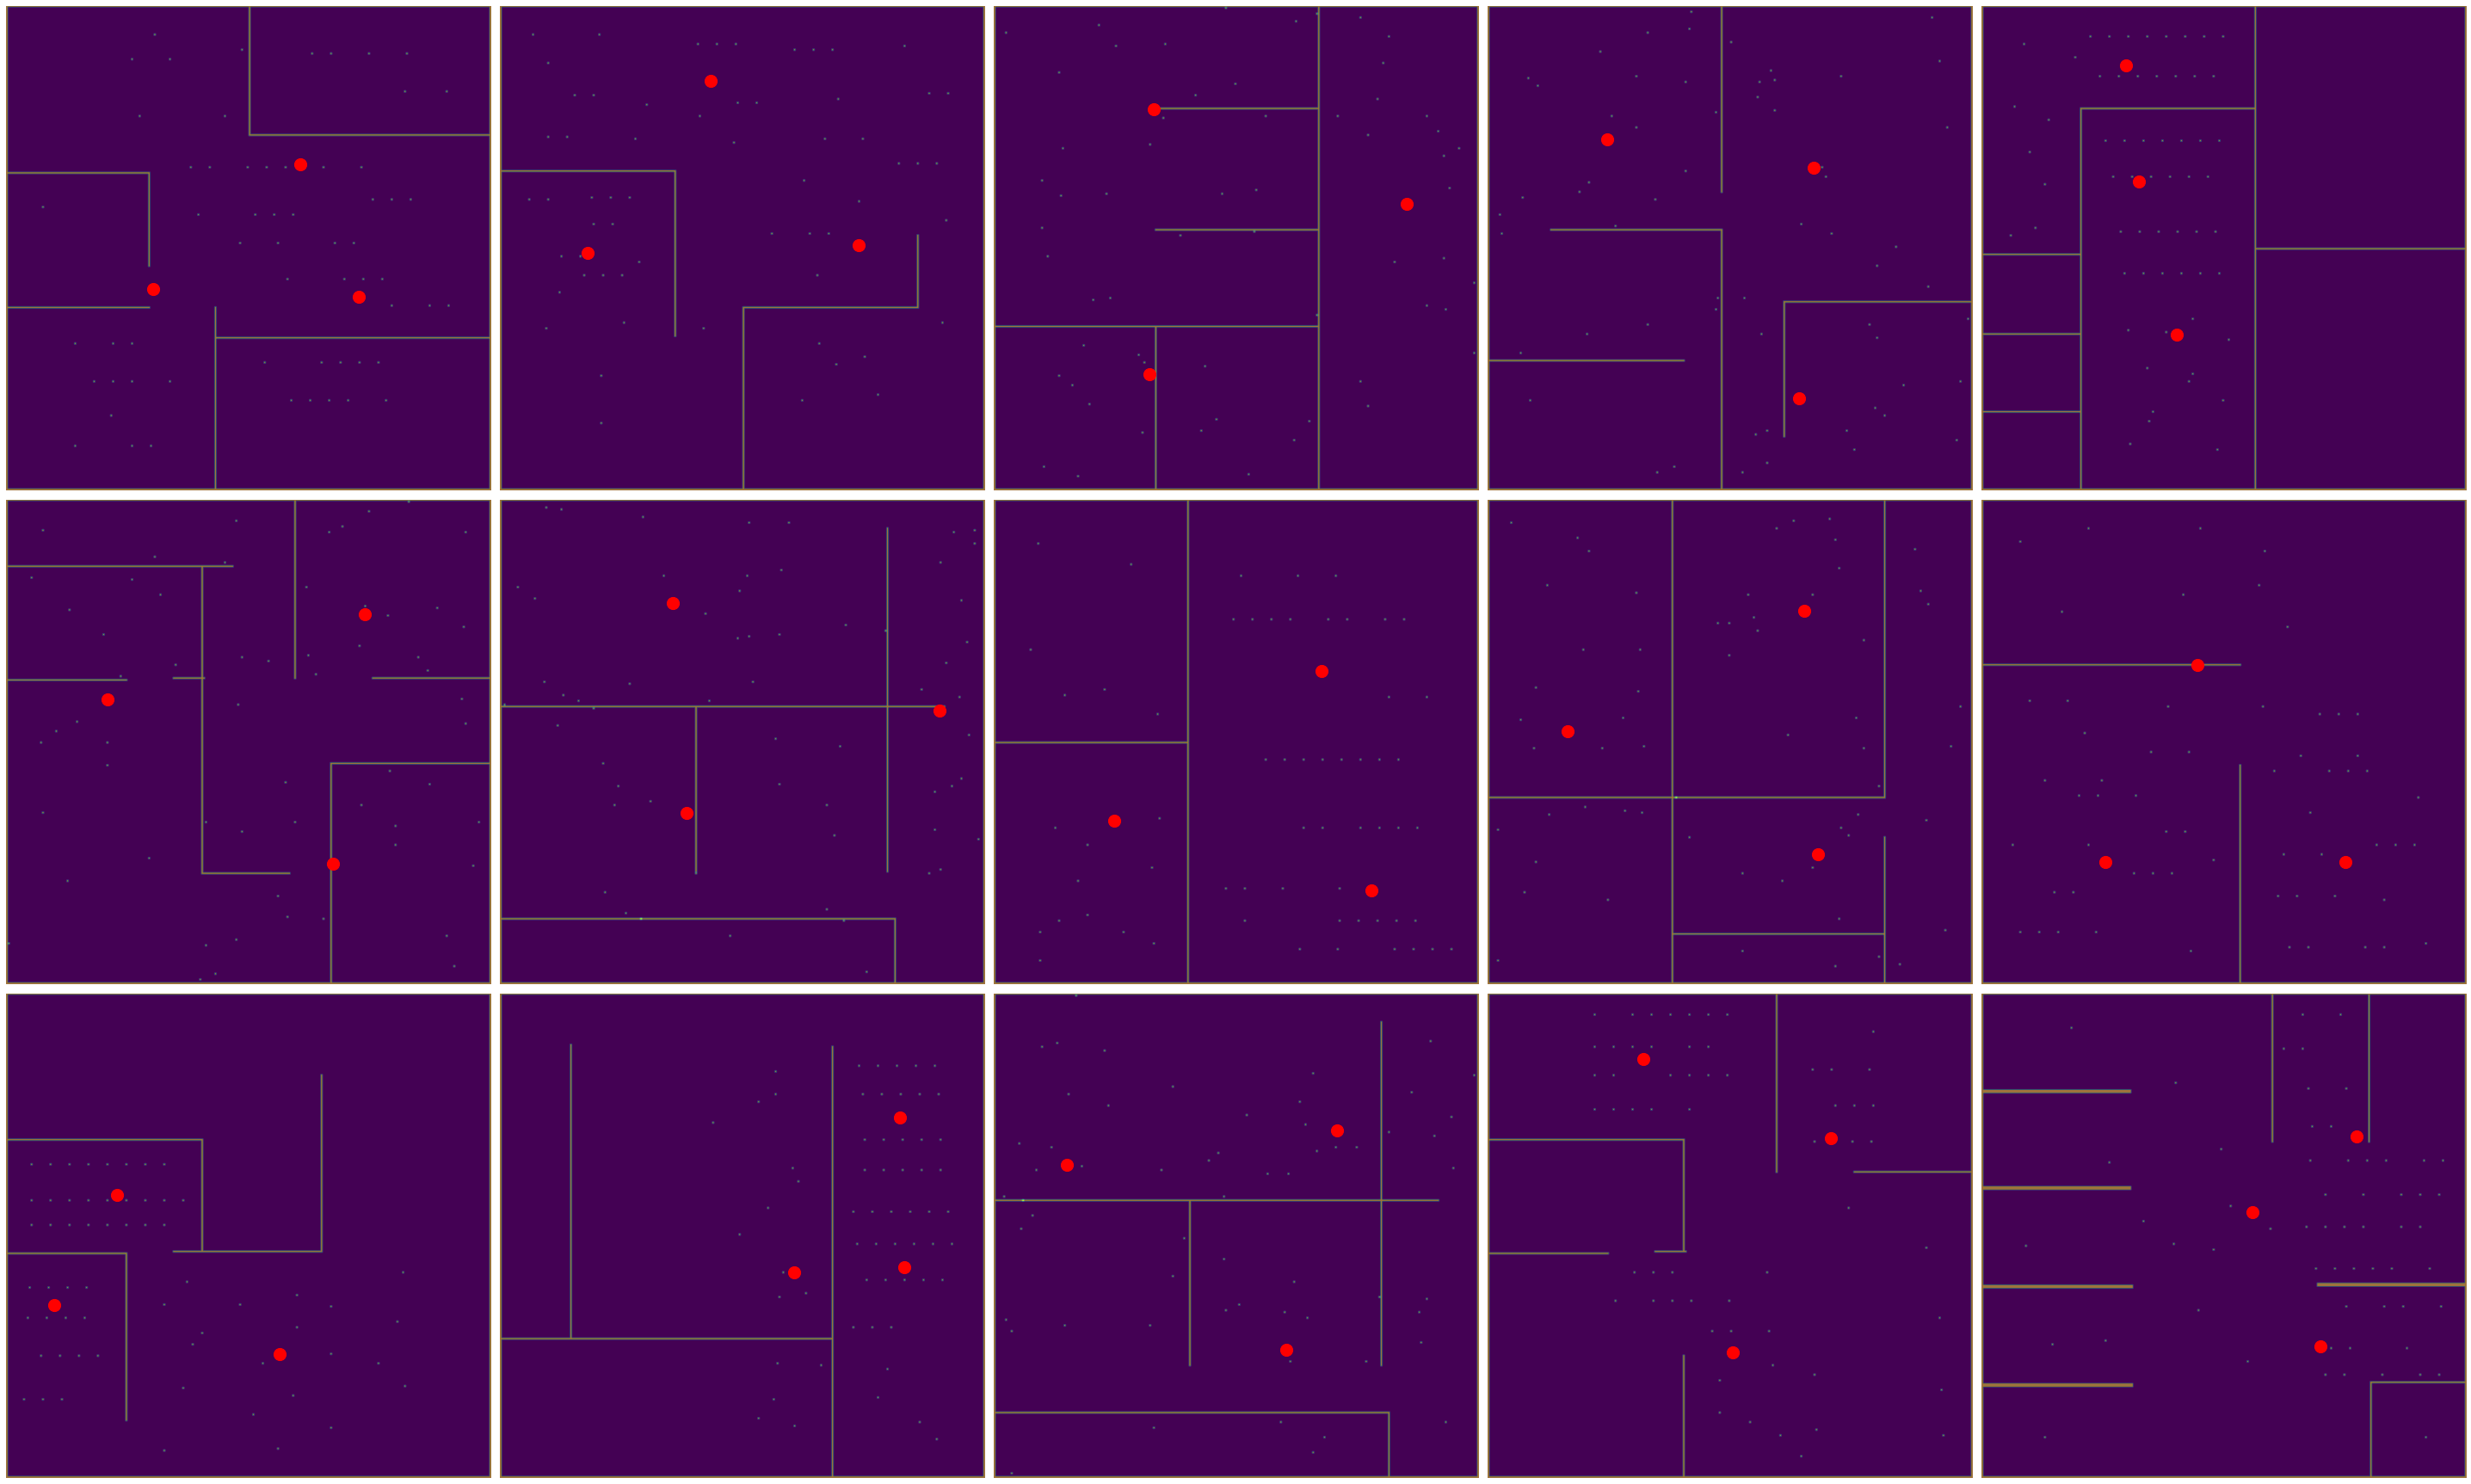

In [14]:
grapics1 = 500
grapics2 = 515
imgs_in = x_train[grapics1:grapics2,...]
imgs_o = y_train[grapics1:grapics2,...]

def plot_data(imgs_in, imgs_o, n_APs):

    plt.figure(figsize=(40,40))
    for i in range(grapics2 - grapics1):

        plt.subplot(5, 5, i+1)
        inp = imgs_in[i,...]
        o = imgs_o[i, ...]

        xt = []
        yt = []
        for j in range(n_APs):
            xt.append(np.round(o[2*j]*255))
            yt.append(np.round(o[2*j+1]*255))

        plt.imshow(inp[:,:,1])
        plt.imshow(inp[:,:,0], alpha = 0.5)

        plt.axis('Off')
        plt.scatter(yt, xt, c='red', s=200)
        # print(xt,yt)

    plt.tight_layout()
    plt.show()

plot_data(imgs_in, imgs_o, n_APs)

In [15]:
channels_img = 2

In [16]:
# def block_2convolution(input_b2, filters, kernel, train=True):
#     conv1 = Conv2D(filters, kernel, padding='same', kernel_initializer='he_normal', trainable=train)(input_b2)
#     batch_norm1 = BatchNormalization(trainable=train)(conv1)
#     act1 = ReLU(trainable=train)(batch_norm1)

#     conv2 = Conv2D(filters, kernel, padding='same', kernel_initializer='he_normal', trainable=train)(act1)
#     batch_norm2 = BatchNormalization(trainable=train)(conv2)
#     act2 = ReLU(trainable=train)(batch_norm2)

#     return act2

# def encoder(input_enc, filters, kernel, train=True):
#     enc1 = block_2convolution(input_enc, filters, kernel, train=train)
#     MaxPool1 = MaxPooling2D(strides=(2, 2), trainable=train)(enc1)
#     return MaxPool1

# def Enco(n_APs=n_APs, higth_img=higth_img, width_img=width_img, channels_img=None):
#     input1 = Input((higth_img, width_img, channels_img))

#     encoder_1_1 = encoder(input1, filters=channels_img*2, kernel=3)
#     encoder_2_1 = encoder(encoder_1_1, filters=40, kernel=3)
#     encoder_3_1 = encoder(encoder_2_1, filters=50, kernel=3)
#     encoder_4_1 = encoder(encoder_3_1, filters=60, kernel=3)
#     encoder_5_1 = encoder(encoder_4_1, filters=100, kernel=3)
#     encoder_6_1 = encoder(encoder_5_1, filters=300, kernel=3)

#     flat = Flatten()(encoder_6_1)

#     Dense2 = Dense(4096, activation='relu')(flat)
#     batch_norm2 = BatchNormalization()(Dense2)  # Agrega BatchNormalization aquí
#     Dense3 = Dense(2048, activation='relu')(batch_norm2)
#     batch_norm3 = BatchNormalization()(Dense3)  # Agrega BatchNormalization aquí
#     Dense4 = Dense(1024, activation='relu')(batch_norm3)
#     batch_norm4 = BatchNormalization()(Dense4)  # Agrega BatchNormalization aquí
#     Dense5 = Dense(512, activation='relu')(batch_norm4)
#     batch_norm5 = BatchNormalization()(Dense5)  # Agrega BatchNormalization aquí
#     Dense6 = Dense(256, activation='relu')(batch_norm5)
#     batch_norm6 = BatchNormalization()(Dense6)  # Agrega BatchNormalization aquí
#     Dense7 = Dense(128, activation='relu')(batch_norm6)
#     batch_norm7 = BatchNormalization()(Dense7)  # Agrega BatchNormalization aquí
#     Dense8 = Dense(64, activation='relu')(batch_norm7)
#     batch_norm8 = BatchNormalization()(Dense8)  # Agrega BatchNormalization aquí
#     Dense9 = Dense(32, activation='relu')(batch_norm8)
#     batch_norm9 = BatchNormalization()(Dense9)  # Agrega BatchNormalization aquí

#     if n_APs == 1:
#         Dense10 = Dense(16, activation='relu')(batch_norm9)
#         batch_norm10 = BatchNormalization()(Dense10)  # Agrega BatchNormalization aquí
#         Dense11 = Dense(8, activation='relu')(batch_norm10)
#         batch_norm11 = BatchNormalization()(Dense11)  # Agrega BatchNormalization aquí
#         Dense12 = Dense(4, activation='relu')(batch_norm11)
#         batch_norm12 = BatchNormalization()(Dense12)  # Agrega BatchNormalization aquí
#         out = Dense(n_APs*2, activation='sigmoid')(batch_norm12)

#     if n_APs == 2 or n_APs == 3:
#         Dense10 = Dense(16, activation='relu')(batch_norm9)
#         batch_norm10 = BatchNormalization()(Dense10)  # Agrega BatchNormalization aquí
#         Dense11 = Dense(8, activation='relu')(batch_norm10)
#         batch_norm11 = BatchNormalization()(Dense11)  # Agrega BatchNormalization aquí
#         out = Dense(n_APs*2, activation='sigmoid')(batch_norm11)

#     if n_APs == 4 or n_APs == 5:
#         Dense10 = Dense(16, activation='relu')(batch_norm9)
#         batch_norm10 = BatchNormalization()(Dense10)  # Agrega BatchNormalization aquí
#         out = Dense(n_APs*2)(batch_norm10)

#     model = Model(input1, out)

#     return model

In [17]:
# ################################################################
# def block_2convolution(input_b2, filters, kernel, train = True):
#     conv1 = Conv2D(filters, kernel, padding = 'same', kernel_initializer='he_normal', trainable = train)(input_b2)
#     batch_norm1 = BatchNormalization(trainable = train)(conv1)
#     act1 = ReLU(trainable = train)(batch_norm1)

#     conv2 = Conv2D(filters, kernel, padding = 'same', kernel_initializer='he_normal', trainable = train)(act1)
#     batch_norm2 = BatchNormalization(trainable = train)(conv2)
#     act2 = ReLU(trainable = train)(batch_norm2)

#     return act2
# ###############################################################
# def encoder(input_enc, filters, kernel, train = True):
#     enc1 = block_2convolution(input_enc, filters, kernel, train = train)
#     MaxPool1 = MaxPooling2D(strides = (2,2), trainable = train)(enc1)
#     return MaxPool1
# ###############################################################
# def Enco(n_APs = n_APs, higth_img = higth_img, width_img = width_img, channels_img = None):

#     # Input
#     input1 = Input((higth_img, width_img, channels_img))

#     #256,256,deep
#     encoder_1_1 = encoder(input1, filters = channels_img*2, kernel = 3) #128,128,deep
#     encoder_2_1 = encoder(encoder_1_1, filters = 40, kernel = 3) #64,64,deep
#     encoder_3_1 = encoder(encoder_2_1, filters = 50, kernel = 3) #32,32,deep
#     encoder_4_1 = encoder(encoder_3_1, filters = 60, kernel = 3) #16,16,deep
#     encoder_5_1 = encoder(encoder_4_1, filters = 100, kernel = 3) #8,8,deep
#     encoder_6_1 = encoder(encoder_5_1, filters = 300, kernel = 3) #4,4,deep

#     flat = Flatten()(encoder_6_1)

#     # Dense1 = Dense(5200, activation='relu')(flat)
#     Dense2 = Dense(4096, activation='relu')(flat)
#     Dense3 = Dense(2048, activation='relu')(Dense2)
#     Dense4 = Dense(1024, activation='relu')(Dense3)
#     Dense5 = Dense(512, activation='relu')(Dense4)
#     Dense6 = Dense(256, activation='relu')(Dense5)
#     Dense7 = Dense(128, activation='relu')(Dense6)
#     Dense8 = Dense(64, activation='relu')(Dense7)
#     Dense9 = Dense(32, activation='relu')(Dense8)

#     if n_APs == 1:
#         Dense10 = Dense(16, activation='relu')(Dense9)
#         Dense11 = Dense(8, activation='relu')(Dense10)
#         Dense12 = Dense(4, activation='relu')(Dense11)
#         out = Dense(n_APs*2, activation='sigmoid')(Dense12)

#     if n_APs == 2 or n_APs == 3:
#         Dense10 = Dense(16, activation='relu')(Dense9)
#         Dense11 = Dense(8, activation='relu')(Dense10)
#         out = Dense(n_APs*2, activation='sigmoid')(Dense11)

#     if n_APs == 4 or n_APs == 5:
#         Dense10 = Dense(16, activation='relu')(Dense9)
#         out = Dense(n_APs*2, activation='sigmoid')(Dense10)

#     model = Model(input1, out)

#     return model
# ###############################################################

In [18]:
def block_2convolution(input_b2, filters, kernel, train=True):
    conv1 = Conv2D(filters, kernel, padding='same', kernel_initializer='he_normal', trainable=train)(input_b2)
    act1 = ReLU()(conv1)

    conv2 = Conv2D(filters, kernel, padding='same', kernel_initializer='he_normal', trainable=train)(act1)
    act2 = ReLU()(conv2)

    return act2
###############################################################
def encoder(input_enc, filters, kernel, train=True):
    enc1 = block_2convolution(input_enc, filters, kernel, train=train)
    MaxPool1 = MaxPooling2D(strides=(2, 2))(enc1)
    return MaxPool1
###############################################################
def Enco(n_APs=n_APs, higth_img=higth_img, width_img=width_img, channels_img=None):

    # Input
    input1 = Input((higth_img, width_img, channels_img))

    # 256,256,deep
    encoder_1_1 = encoder(input1, filters=channels_img*2, kernel=3) #128,128,deep
    encoder_2_1 = encoder(encoder_1_1, filters=40, kernel=3) #64,64,deep
    encoder_3_1 = encoder(encoder_2_1, filters=50, kernel=3) #32,32,deep
    encoder_4_1 = encoder(encoder_3_1, filters=60, kernel=3) #16,16,deep
    encoder_5_1 = encoder(encoder_4_1, filters=100, kernel=3) #8,8,deep
    encoder_6_1 = encoder(encoder_5_1, filters=300, kernel=3) #4,4,deep

    flat = Flatten()(encoder_6_1)

    Dense2 = Dense(4096, activation='relu')(flat)
    Dense3 = Dense(2048, activation='relu')(Dense2)
    Dense4 = Dense(1024, activation='relu')(Dense3)
    Dense5 = Dense(512, activation='relu')(Dense4)
    Dense6 = Dense(256, activation='relu')(Dense5)
    Dense7 = Dense(128, activation='relu')(Dense6)
    Dense8 = Dense(64, activation='relu')(Dense7)
    Dense9 = Dense(32, activation='relu')(Dense8)

    if n_APs == 1:
        Dense10 = Dense(16, activation='relu')(Dense9)
        Dense11 = Dense(8, activation='relu')(Dense10)
        Dense12 = Dense(4, activation='relu')(Dense11)
        out = Dense(n_APs*2)(Dense12)

    if n_APs == 2 or n_APs == 3:
        Dense10 = Dense(16, activation='relu')(Dense9)
        Dense11 = Dense(8, activation='relu')(Dense10)
        out = Dense(n_APs*2)(Dense11)

    if n_APs == 4 or n_APs == 5:
        Dense10 = Dense(16, activation='relu')(Dense9)
        out = Dense((n_APs*2))(Dense10)

    model = Model(input1, out)

    return model

In [19]:
# def block_2convolution(input_b2, filters, kernel, train=True):
#     conv1 = Conv2D(filters, kernel, padding='same', kernel_initializer='he_normal', trainable=train)(input_b2)
#     act1 = ReLU()(conv1)

#     conv2 = Conv2D(filters, kernel, padding='same', kernel_initializer='he_normal', trainable=train)(act1)
#     act2 = ReLU()(conv2)

#     return act2
# ###############################################################
# def encoder(input_enc, filters, kernel, train=True):
#     enc1 = block_2convolution(input_enc, filters, kernel, train=train)
#     MaxPool1 = MaxPooling2D(strides=(2, 2))(enc1)
#     return MaxPool1
# ###############################################################

# def Enco(n_APs=n_APs, higth_img=higth_img, width_img=width_img, channels_img=None, dropout_rate=0.25):

#     # Input
#     input1 = Input((higth_img, width_img, channels_img))

#     # 256,256,deep
#     encoder_1_1 = encoder(input1, filters=channels_img*2, kernel=3) #128,128,deep
#     encoder_2_1 = encoder(encoder_1_1, filters=40, kernel=3) #64,64,deep
#     encoder_3_1 = encoder(encoder_2_1, filters=50, kernel=3) #32,32,deep
#     encoder_4_1 = encoder(encoder_3_1, filters=60, kernel=3) #16,16,deep
#     encoder_5_1 = encoder(encoder_4_1, filters=100, kernel=3) #8,8,deep
#     encoder_6_1 = encoder(encoder_5_1, filters=300, kernel=3) #4,4,deep

#     flat = Flatten()(encoder_6_1)

#     Dense2 = Dense(4096, activation='relu')(flat)
#     Dense2 = Dropout(dropout_rate)(Dense2)  # Agregar Dropout con tasa del 25%
#     Dense3 = Dense(2048, activation='relu')(Dense2)
#     Dense3 = Dropout(dropout_rate)(Dense3)
#     Dense4 = Dense(1024, activation='relu')(Dense3)
#     Dense4 = Dropout(dropout_rate)(Dense4)
#     Dense5 = Dense(512, activation='relu')(Dense4)
#     Dense5 = Dropout(dropout_rate)(Dense5)
#     Dense6 = Dense(256, activation='relu')(Dense5)
#     Dense6 = Dropout(dropout_rate)(Dense6)
#     Dense7 = Dense(128, activation='relu')(Dense6)
#     Dense7 = Dropout(dropout_rate)(Dense7)
#     Dense8 = Dense(64, activation='relu')(Dense7)
#     Dense8 = Dropout(dropout_rate)(Dense8)
#     Dense9 = Dense(32, activation='relu')(Dense8)
#     Dense9 = Dropout(dropout_rate)(Dense9)

#     if n_APs == 1:
#         Dense10 = Dense(16, activation='relu')(Dense9)
#         Dense10 = Dropout(dropout_rate)(Dense10)
#         Dense11 = Dense(8, activation='relu')(Dense9)
#         Dense11 = Dropout(dropout_rate)(Dense11)
#         Dense12 = Dense(4, activation='relu')(Dense10)
#         Dense12 = Dropout(dropout_rate)(Dense12)
#         out = Dense(n_APs*2)(Dense12)

#     if n_APs == 2 or n_APs == 3:
#         Dense10 = Dense(16, activation='relu')(Dense9)
#         Dense10 = Dropout(dropout_rate)(Dense10)
#         Dense11 = Dense(8, activation='relu')(Dense10)
#         Dense11 = Dropout(dropout_rate)(Dense11)
#         out = Dense(n_APs*2)(Dense11)

#     if n_APs == 4 or n_APs == 5:
#         Dense10 = Dense(16, activation='relu')(Dense9)
#         Dense10 = Dropout(dropout_rate)(Dense10)
#         out = Dense((n_APs*2))(Dense10)

#     model = Model(input1, out)

#     return model


In [20]:
model = Enco(n_APs = n_APs, higth_img = higth_img, width_img = width_img, channels_img = channels_img)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [21]:
# model.summary()

In [22]:
# Parameters for cross validation
n_splits = 5
kf = KFold(n_splits = n_splits)

# Lists metrics
scores_loss = []
scores_rmse = []
scores_mae = []

hist_arr = []

In [23]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = learning_rate,
    decay_steps = 10000,
    decay_rate = 0.30)
# optimizer = optimizers.SGD(learning_rate = lr_schedule)
optimizer = optimizers.Adam(learning_rate = lr_schedule)

model.compile(optimizer = optimizer, loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError(),
                                                                             tf.keras.metrics.MeanAbsoluteError()])

In [24]:
def training(dir_dataset = dir_dataset, model = model, n_splits = n_splits,
             n_APs = n_APs, x_train = x_train, y_train = y_train,
             epochs = epochs, batch_size = batch_size): # Se usa validación cruzada

    callbacks = [keras.callbacks.ModelCheckpoint(dir_models +
                                                    str(n_APs) + add_name_save + '_model.h5',
                                                    save_best_only = True)]

    s_loss =  1e6

    fold_no = 1

    for train_index, val_index in kf.split(x_train):

        print(f'Fold: {fold_no}')
        X_train_cv, X_val_cv = x_train[train_index], x_train[val_index]
        y_train_cv, y_val_cv = y_train[train_index], y_train[val_index]

        hist = model.fit(X_train_cv, y_train_cv,
                    batch_size = batch_size,
                    verbose = 1,
                    epochs = epochs//n_splits,
                    validation_data = (X_val_cv, y_val_cv),
                    callbacks = callbacks,
                    shuffle = False)

        hist_arr.append(hist)

        # Model test
        score = model.evaluate(X_val_cv, y_val_cv, verbose=0)
        print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {score[0]}; {model.metrics_names[1]} of {score[1]}; {model.metrics_names[2]} of {score[2]}')

        if s_loss > score[0]:
            s_loss = score[0]
            print(f"The best metrics fold: {fold_no} --- loss: {score[0]}; rmse {score[1]}; mae: {score[2]}")

        scores_loss.append(score[0])
        scores_rmse.append(score[1])
        scores_mae.append(score[2])
        fold_no += 1

        X_train_cv = None
        X_val_cv = None
        y_train_cv = None
        y_val_cv = None
        train_index = None
        val_index = None

    # Average results cross validation
    # print(f'Loss: {np.mean(scores_loss)}; rmse: {np.mean(scores_rmse)}; mae: {np.mean(scores_mae)}')

    # return scores_loss, scores_rmse, scores_mae, hist_arr
    return hist_arr

    ###############################################################################

In [ ]:
# scores_loss, scores_rmse, scores_mae, hist_arr = training()
hist_arr = training()

In [25]:
model = load_model(dir_models + str(n_APs) + add_name_save + '_model.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
# model.load_weights(dir_models + str(n_APs) + '_model.h5')

In [ ]:
# Save data metrcis
np.save(dir_models + str(n_APs) + add_name_save + '_metrics_loss.npy', np.array(scores_loss))
np.save(dir_models + str(n_APs) + add_name_save + '_metrics_rmse.npy', np.array(scores_rmse))
np.save(dir_models + str(n_APs) + add_name_save + '_metrics_mae.npy', np.array(scores_mae))

In [ ]:
def extract_metrics(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    rmse = history.history['root_mean_squared_error']
    val_rmse = history.history['val_root_mean_squared_error']
    mae = history.history['mean_absolute_error']
    val_mae = history.history['val_mean_absolute_error']
    return loss, val_loss, rmse, val_rmse, mae, val_mae

In [ ]:
losses = []
val_losses = []

rmse_scores = []
val_rmse_scores = []
mae_scores = []
val_mae_scores = []

In [ ]:
for history in hist_arr:
    loss, val_loss, rmse, val_rmse, mae, val_mae = extract_metrics(history)
    losses.append(loss)
    val_losses.append(val_loss)
    rmse_scores.append(rmse)
    val_rmse_scores.append(val_rmse)
    mae_scores.append(mae)
    val_mae_scores.append(val_mae)

In [ ]:
np.savez(dir_models + str(n_APs) + add_name_save + '_history.npz',
    losses = losses,
    val_losses = val_losses,
    rmse_scores = rmse_scores,
    val_rmse_scores = val_rmse_scores,
    mae_scores = mae_scores,
    val_mae_scores = val_mae_scores)

In [ ]:
loaded_arrays = np.load(dir_models + str(n_APs) + add_name_save + '_history.npz')

losses = loaded_arrays['losses']
val_losses = loaded_arrays['val_losses']

rmse_scores = loaded_arrays['rmse_scores']
val_rmse_scores = loaded_arrays['val_rmse_scores']
mae_scores = loaded_arrays['mae_scores']
val_mae_scores = loaded_arrays['val_mae_scores']

In [ ]:
mean_loss = np.mean(losses, axis=0)
mean_val_loss = np.mean(val_losses, axis=0)

mean_rmse = np.mean(rmse_scores, axis=0)
mean_val_rmse = np.mean(val_rmse_scores, axis=0)
mean_mae = np.mean(mae_scores, axis=0)
mean_val_mae = np.mean(val_mae_scores, axis=0)

In [ ]:
epochs = range(1, len(mean_loss) + 1)

# Primera figura para las métricas de pérdida
fig1, ax1 = plt.subplots()
ax1.plot(epochs, mean_loss, label='Training Loss', linestyle='-', color='blue')
ax1.plot(epochs, mean_val_loss, label='Validation Loss', linestyle='--', color='blue')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Metrics')
ax1.legend()
ax1.grid(True)

plt.tight_layout()
plt.show()

# Segunda figura para las otras métricas
fig2, ax2 = plt.subplots()
ax2.plot(epochs, mean_rmse*20, label='Training RMSE', linestyle='-', color='red')
ax2.plot(epochs, mean_val_rmse*20, label='Validation RMSE', linestyle='--', color='red')
ax2.plot(epochs, mean_mae*20, label='Training MAE', linestyle='-', color='blue')
ax2.plot(epochs, mean_val_mae*20, label='Validation MAE', linestyle='--', color='blue')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Metric Value')
ax2.set_title('Other Metrics')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


Time used was: 0.12168645858764648 seconds
Shape output: (6,)
Real coordinates in meters:
Coordinate AP 1: x = 4.8628, y = 14.745
Coordinate AP 2: x = 6.6666, y = 6.9804
Coordinate AP 3: x = 15.2942, y = 11.7648

Predictions coordinates in meters:
Coordinate AP 1: x = 4.38058, y = 14.43385
Coordinate AP 2: x = 7.18383, y = 5.2633
Coordinate AP 3: x = 14.14701, y = 13.20967
1/1 [==============================] - 0s 81ms/sample - loss: 0.0029 - root_mean_squared_error: 0.0538 - mean_absolute_error: 0.0468
Score for data individual test: loss of 0.0029; root_mean_squared_error of 1.07618 meters; mean_absolute_error of 0.04682999849319458


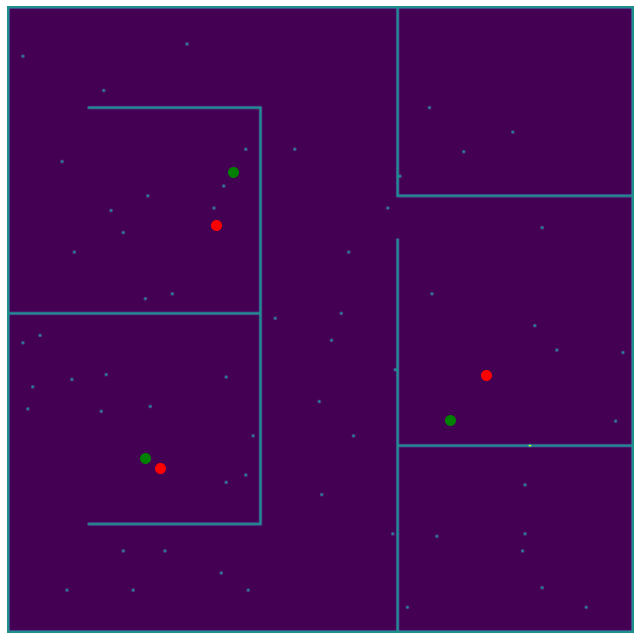

[0.7216927  0.21902882 0.26316488 0.35919166 0.66048336 0.7073506 ]


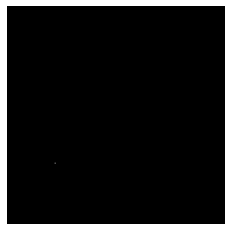

Imagen guardada como G:/Otros ordenadores/False-2-Tesis-Maestria/DataSet5GHz/Users-and-APsOpti-final/Results/3_1-1.png


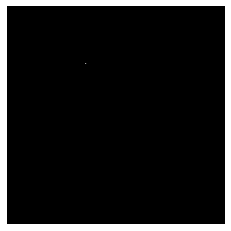

Imagen guardada como G:/Otros ordenadores/False-2-Tesis-Maestria/DataSet5GHz/Users-and-APsOpti-final/Results/3_2-1.png


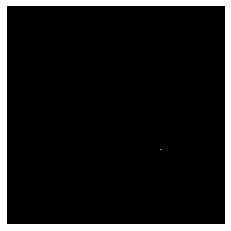

Imagen guardada como G:/Otros ordenadores/False-2-Tesis-Maestria/DataSet5GHz/Users-and-APsOpti-final/Results/3_3-1.png


In [31]:
test_img_number = random.randint(0, len(x_test)-1)
test_img = x_test[test_img_number]
ground_truth = y_test[test_img_number]
test_img_input = np.expand_dims(test_img, 0)
inicio = time.time()
prediction = model.predict(test_img_input)
prediction = prediction.squeeze()
fin = time.time()
print(f'Time used was: {fin-inicio} seconds')
print(f"Shape output: {prediction.shape}")
print('Real coordinates in meters:')
# print(f"Output real: {ground_truth}")
# print(f"Output pred: {prediction}")

coordinate_pairs = [(np.round(ground_truth[i]*20,5), np.round(ground_truth[i + 1]*20,5)) for i in range(0, len(ground_truth), 2)]

for i, (x, y) in enumerate(coordinate_pairs, start=1):
    print(f"Coordinate AP {i}: x = {y}, y = {x}")

print()
print('Predictions coordinates in meters:')
coordinate_pairs = [(np.round(prediction[i]*20,5), np.round(prediction[i + 1]*20,5)) for i in range(0, len(prediction), 2)]

for i, (x, y) in enumerate(coordinate_pairs, start=1):
    print(f"Coordinate AP {i}: x = {y}, y = {x}")

xt = []
yt = []
for j in range(n_APs):
    xt.append((ground_truth[2*j]*255))
    yt.append((ground_truth[2*j+1]*255))

xp = []
yp = []
for j in range(n_APs):
    xp.append((prediction[2*j]*255))
    yp.append((prediction[2*j+1]*255))

test_img = np.expand_dims(test_img, axis=0)
ground_truth = np.expand_dims(ground_truth, axis=0)

# print(f"test_img output: {test_img.shape}")
# print(f"ground_truth output: {ground_truth.shape}")

model.compile(optimizer = optimizer, loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError(),
                                                                             tf.keras.metrics.MeanAbsoluteError()])

score = model.evaluate(test_img_input, ground_truth)

print(f'Score for data individual test: {model.metrics_names[0]} of {np.round(score[0],5)}; {model.metrics_names[1]} of {np.round(score[1]*20,5)} meters; {model.metrics_names[2]} of {np.round(score[2],5)}')

plt.figure(figsize=(9,9))

inp = test_img_input[0,...]
plt.imshow(inp[:,:,1]+inp[:,:,0])
# plt.imshow(inp[:,:,0], alpha = 0.5)

plt.axis('Off')
plt.tight_layout()
plt.scatter(yt, xt, c='red', s=100)
plt.scatter(yp, xp, c='green', s=100)

plt.savefig('G:/Otros ordenadores/False-2-Tesis-Maestria/DataSet5GHz/Users-and-APsOpti-final/Results/op_des_3_ap-1.png')

plt.show()

# # Cálculo del error cuadrado
# squared_errors = (ground_truth - prediction) ** 2

# # Cálculo del RMSE
# rmse = np.sqrt(np.mean(squared_errors))

# print("RMSE calculated:", rmse)


# **************************************************************************************************


print((prediction))

prediction1 = np.round((prediction)*255).astype(int)

# Supongamos que tienes un vector de coordenadas en el formato [x1, y1, x2, y2, ...]
# Asegúrate de que tenga una longitud par para que las coordenadas estén emparejadas
coordinates = prediction1  # Reemplaza con tus coordenadas

# Definir el tamaño de la imagen
image_size = 256

# Iterar a través de las coordenadas en pares
for i in range(0, len(coordinates), 2):
    x, y = coordinates[i], coordinates[i + 1]

    # Crear una matriz de ceros de tamaño 256x256
    image = np.zeros((image_size, image_size), dtype=np.uint8)

    # Verificar que las coordenadas estén dentro de los límites de la imagen
    if 0 <= x < image_size and 0 <= y < image_size:
        # Establecer el punto en 255
        image[x, y] = 255  # Invierte las coordenadas (y, x) para que coincidan con la imagen

        # Crear una imagen de Pillow
        img = Image.fromarray(image)

        # Definir el nombre del archivo basado en las coordenadas
        file_name = f'G:/Otros ordenadores/False-2-Tesis-Maestria/DataSet5GHz/Users-and-APsOpti-final/Results/{n_APs}_{int((i/2)+1)}-1.png'

        # Guardar la imagen en un archivo
        # plt.imsave(file_name, image, cmap='gray', vmin=0, vmax=255, format='png', dpi=100)
        # Guardar la imagen con profundidad de 8 bits
        img.save(file_name, 'PNG')


        # Mostrar la imagen (opcional)
        plt.imshow(image, cmap='gray')
        plt.axis('off')  # Para ocultar los ejes
        plt.show()

        print(f'Imagen guardada como {file_name}')


In [26]:
model.compile(optimizer = optimizer, loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError(),
                                                                             tf.keras.metrics.MeanAbsoluteError()])
score = model.evaluate(x_test, y_test, verbose=0)
print(f'Score for data test: {model.metrics_names[0]} of {score[0]}; {model.metrics_names[1]} of {np.round(score[1]*20,5)} meters; {model.metrics_names[2]} of {score[2]}')

Score for data test: loss of 0.04433956270416577; root_mean_squared_error of 4.21139 meters; mean_absolute_error of 0.13905136287212372
